# 可选实验室：特征缩放和学习率（多变量）

## 目标

在本实验室中，您将：

- 利用之前实验室开发的多变量例程
- 在具有多个特征的数据集上运行梯度下降
- 探索*学习率alpha*对梯度下降的影响
- 使用Z-score归一化通过*特征缩放*来提高梯度下降的性能

## 工具

您将利用上一个实验中开发的函数以及matplotlib和NumPy。

In [120]:
import numpy as np

np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

dlblue = '#0096ff'
dlorange = '#FF9300'
dldarkred = '#C00000'
dlmagenta = '#FF40FF'
dlpurple = '#7030A0'
plt.style.use('deeplearning.mplstyle')
from lab_utils_multi import load_house_data, run_gradient_descent
from lab_utils_multi import norm_plot, plt_equal_scale, plot_cost_i_w

## 符号

| 一般符号                                            | 描述                                                                                                                                      | Python（如果适用）  |
|:------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------|:--------------|
| $a$                                             | 标量，非粗体                                                                                                                                  |               |
| $\mathbf{a}$                                    | 矢量，粗体                                                                                                                                   |               |
| $\mathbf{A}$                                    | 矩阵，粗体大写                                                                                                                                 |               |
| **回归**                                          |                                                                                                                                         |               | |
| $\mathbf{X}$                                    | 训练示例 maxtrix                                                                                                                            | `X_train`     |
| $\mathbf{y}$                                    | 训练示例目标                                                                                                                                  | `y_train`     |
| $\mathbf{x}^{(i)}$, $y^{(i)}$                   | $i_{th}$训练示例                                                                                                                            | `X[i]`，`y[i]` |
| m                                               | 训练样本数量                                                                                                                                  | `m`           |
| n                                               | 每个示例中的特征数量                                                                                                                              | `n`           |
| $\mathbf{w}$                                    | 参数：重量，                                                                                                                                  | `w`           |
| $b$                                             | 参数：偏差                                                                                                                                   | `b`           |
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$            | 由 $\mathbf{w},b$ 参数化的 $\mathbf{x}^{(i)}$ 处的模型评估结果： $f_{\mathbf{w},b}(\mathbf{x}^ {(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$          | `f_wb`        |
| $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ | 成本相对于参数 $w_j$         的梯度或偏导数                                                                                                           | `dj_dw[j]`    | 
| $\frac{\partial J(\mathbf{w},b)}{\partial b}$   | 成本相对于参数 $b$                                                                                                                     的梯度或偏导数 | `dj_db`       |


# 问题陈述

与之前的实验一样，您将使用房价预测的激励示例。训练数据集包含许多示例，具有4个特征（大小、卧室、楼层和年龄），如下表所示。请注意，在本实验室中，尺寸特征以平方英尺为单位，而早期的实验室使用1000平方英尺。该数据集比之前的实验室更大。

我们希望使用这些值建立一个线性回归模型，以便我们可以预测其他房屋的价格——例如，一栋1200平方英尺、3间卧室、一层、40年楼龄的房屋。

## 数据集：

| 尺寸（平方英尺） | 卧室数量     | 楼层数      | 家庭时代     | 价格（千元）   |
|----------|----------|----------|----------|----------|
| 952      | 2        | 1        | 65       | 271.5    | 
| 1244     | 3        | 2        | 64       | 232      | 
| 1947     | 3        | 2        | 17       | 509.8    |
| $\cdots$ | $\cdots$ | $\cdots$ | $\cdots$ | $\cdots$ |

In [121]:
X_train, y_train = load_house_data()
X_features = ['size(sqft)', 'bedrooms', 'floors', 'age']

让我们通过绘制每个特征与价格的关系来查看数据集及其特征。

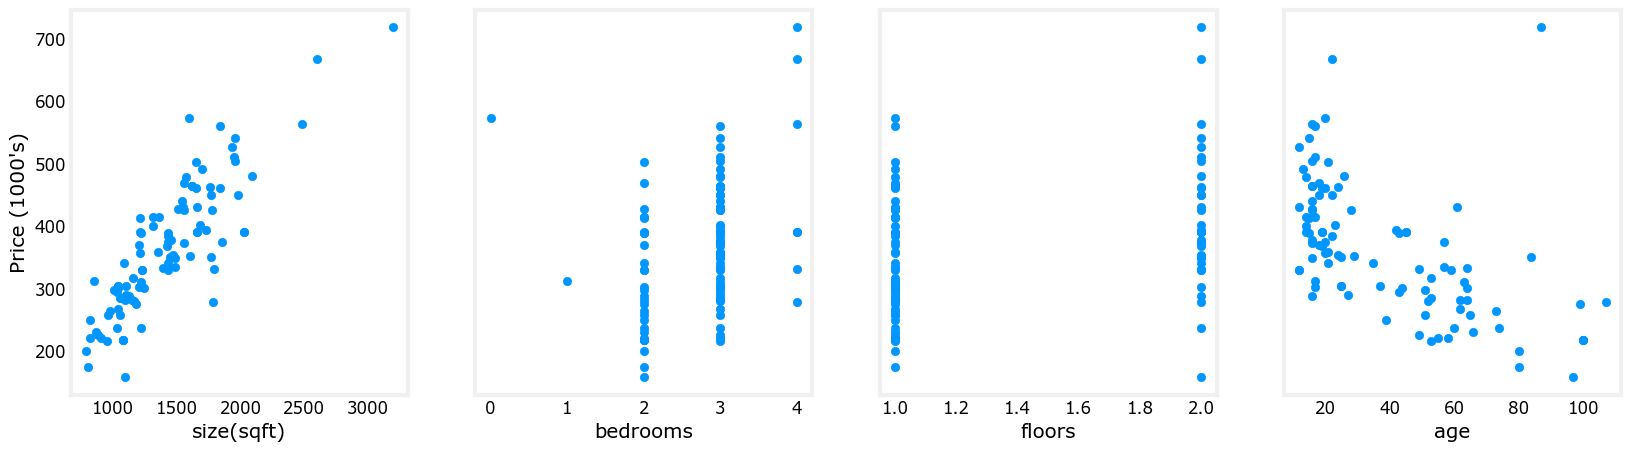

In [122]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

绘制每个功能与目标价格的关系图，可以提供一些关于哪些功能对价格影响最大的指示。如上所述，尺寸的增加也会导致价格的上涨。卧室和地板似乎对价格没有太大影响。新房子的价格比旧房子高。

## 多变量梯度下降

以下是您在上一个关于多变量梯度下降的实验中开发的方程：

# 5 多变量梯度下降

多变量的梯度下降：

重复直到收敛

$$w_j=w_j-\alpha\frac{\partial J(\mathbf{w},b)}{\partial w_j}\tag{1}\;\text{for j=0,1,\cdots,n-1}$$
$$b=b-\alpha\frac{\partial J(\mathbf{w},b)}{\partial b}$$

其中，n是特征数量，参数$w_j$、$b$同时更新，其中

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3}
\end{align}
$$

* m是数据集中训练样本的数量

* $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$是模型的预测，而$y^{(i)}$是目标值

## 学习率
<figure>
    <img src="../../images/C1_W2_Lab06_learningrate.PNG" style="width:1200px;" >
</figure>

讲座讨论了一些与设置学习率$\alpha$相关的问题。学习率控制参数更新的大小。参见上面的等式（1）。它由所有参数共享。

让我们运行梯度下降并在我们的数据集上尝试一些$\alpha$设置

### $\alpha$=9.9e-7

In [123]:
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha=9.9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 9.55884e+04  5.5e-01  1.0e-03  5.1e-04  1.2e-02  3.6e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 1.28213e+05 -8.8e-02 -1.7e-04 -1.0e-04 -3.4e-03 -4.8e-05  6.4e+05  1.2e+03  6.2e+02  1.6e+04  4.1e+02
        2 1.72159e+05  6.5e-01  1.2e-03  5.9e-04  1.3e-02  4.3e-04 -7.4e+05 -1.4e+03 -7.0e+02 -1.7e+04 -4.9e+02
        3 2.31358e+05 -2.1e-01 -4.0e-04 -2.3e-04 -7.5e-03 -1.2e-04  8.6e+05  1.6e+03  8.3e+02  2.1e+04  5.6e+02
        4 3.11100e+05  7.9e-01  1.4e-03  7.1e-04  1.5e-02  5.3e-04 -1.0e+06 -1.8e+03 -9.5e+02 -2.3e+04 -6.6e+02
        5 4.18517e+05 -3.7e-01 -7.1e-04 -4.0e-04 -1.3e-02 -2.1e-04  1.2e+06  2.1e+03  1.1e+03  2.8e+04  7.5e+02
        6 5.63212e+05  9.7e-01  1.7e-03  8.7e-04  1.8e-02  6.6e-04 -1.3e+06 -2.5e+03 -1.3e+03 -3.1e+04 -

看来学习率太高了。解不收敛。成本正在*增加*而不是减少。让我们绘制结果：

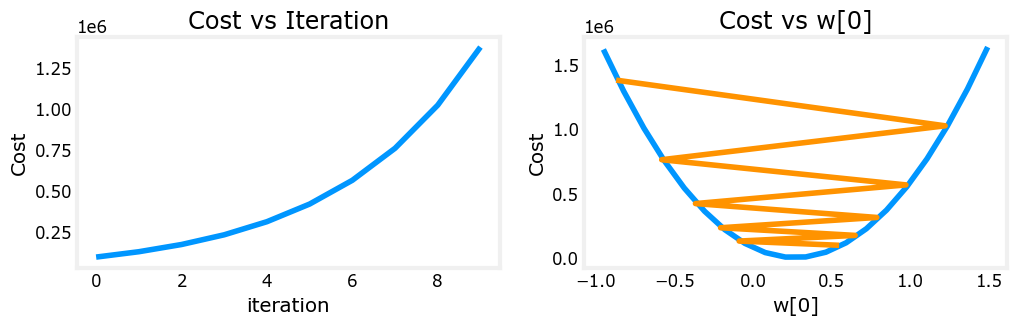

In [124]:
plot_cost_i_w(X_train, y_train, hist)

右图显示了参数之一$w_0$的值。在每次迭代中，它都会超出最佳值，因此，成本最终*增加*而不是接近最小值。请注意，这并不是一张完全准确的图片，因为每次传递都会修改4个参数，而不仅仅是一个。该图仅显示$w_0$，其他参数固定为良性值。在此图和后面的图中，您可能会注意到蓝色和橙色线略有偏离。

### $\alpha$=9e-7

让我们尝试一个更小的值，看看会发生什么。

In [125]:
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha=9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 6.64616e+04  5.0e-01  9.1e-04  4.7e-04  1.1e-02  3.3e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 6.18990e+04  1.8e-02  2.1e-05  2.0e-06 -7.9e-04  1.9e-05  5.3e+05  9.8e+02  5.2e+02  1.3e+04  3.4e+02
        2 5.76572e+04  4.8e-01  8.6e-04  4.4e-04  9.5e-03  3.2e-04 -5.1e+05 -9.3e+02 -4.8e+02 -1.1e+04 -3.4e+02
        3 5.37137e+04  3.4e-02  3.9e-05  2.8e-06 -1.6e-03  3.8e-05  4.9e+05  9.1e+02  4.8e+02  1.2e+04  3.2e+02
        4 5.00474e+04  4.6e-01  8.2e-04  4.1e-04  8.0e-03  3.2e-04 -4.8e+05 -8.7e+02 -4.5e+02 -1.1e+04 -3.1e+02
        5 4.66388e+04  5.0e-02  5.6e-05  2.5e-06 -2.4e-03  5.6e-05  4.6e+05  8.5e+02  4.5e+02  1.2e+04  2.9e+02
        6 4.34700e+04  4.5e-01  7.8e-04  3.8e-04  6.4e-03  3.2e-04 -4.4e+05 -8.1e+02 -4.2e+02 -9.8e+03 -

整个运行过程中成本不断下降，表明$\alpha$并不太大。

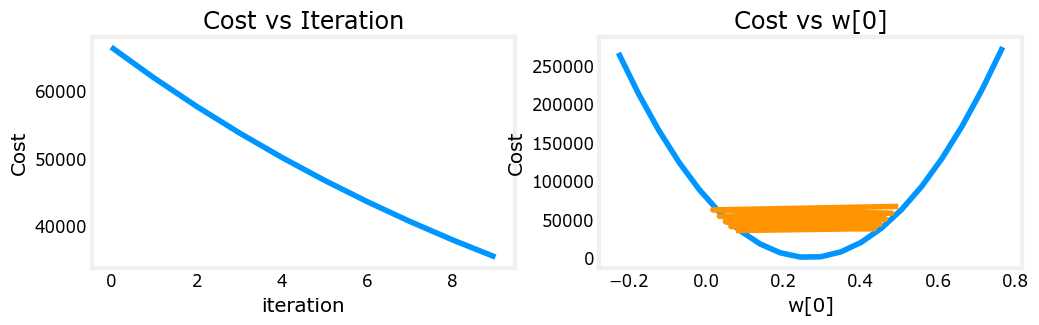

In [126]:
plot_cost_i_w(X_train, y_train, hist)

在左侧，您可以看到成本正在按预期下降。在右侧，您可以看到$w_0$仍在最小值附近振荡，但每次迭代它都在减少而不是增加。请注意，上面`dj_dw[0]`随着每次迭代而改变符号，因为`w[0]`跳过了最佳值。
该$\alpha$值将会收敛。您可以改变迭代次数以查看其行为。

### $\alpha$=1e-7

让我们尝试为$\alpha$尝试一个更小的值，看看会发生什么。

In [127]:
_, _, hist = run_gradient_descent(X_train, y_train, 1000, alpha=1e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 4.42313e+04  5.5e-02  1.0e-04  5.2e-05  1.2e-03  3.6e-05 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
      100 1.57604e+03  2.5e-01  4.0e-04  1.6e-04 -7.7e-04  2.1e-04 -1.6e+01  6.5e+00  8.3e+00  6.7e+02 -4.4e+00
      200 1.57164e+03  2.5e-01  3.3e-04  7.4e-05 -7.4e-03  2.5e-04 -1.6e+01  6.5e+00  8.3e+00  6.6e+02 -4.4e+00
      300 1.56732e+03  2.5e-01  2.7e-04 -8.5e-06 -1.4e-02  3.0e-04 -1.6e+01  6.4e+00  8.3e+00  6.5e+02 -4.4e+00
      400 1.56308e+03  2.5e-01  2.0e-04 -9.1e-05 -2.0e-02  3.4e-04 -1.5e+01  6.4e+00  8.3e+00  6.5e+02 -4.5e+00
      500 1.55891e+03  2.5e-01  1.4e-04 -1.7e-04 -2.7e-02  3.9e-04 -1.5e+01  6.3e+00  8.3e+00  6.4e+02 -4.5e+00
      600 1.55483e+03  2.5e-01  7.9e-05 -2.6e-04 -3.3e-02  4.3e-04 -1.5e+01  6.2e+00  8.3e+00  6.4e+02 -

整个运行过程中成本不断下降，表明$\alpha$并不太大。

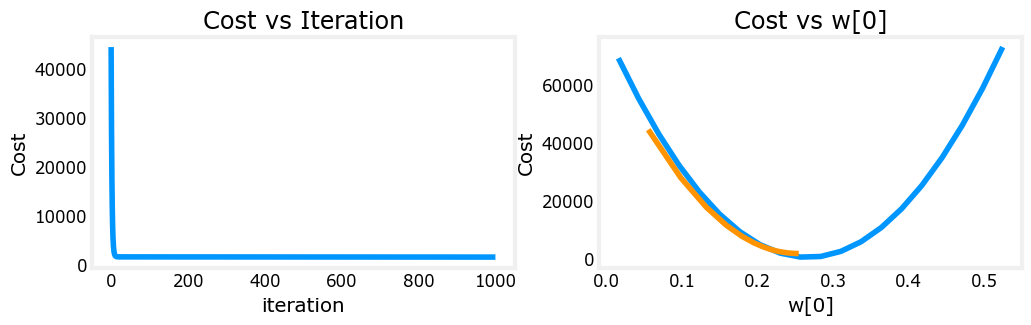

In [128]:
plot_cost_i_w(X_train, y_train, hist)

在左侧，您可以看到成本正在按预期下降。在右侧，您可以看到$w_0$正在减少，但没有超过最小值。请注意，上面的`dj_w0`在整个运行过程中均为负值。该解决方案也将收敛，但速度不如前一个示例。

## 特征缩放

<figure>
    <img src="../../images/C1_W2_Lab06_featurescalingheader.PNG" style="width:1200px;" >
</figure>

这些讲座描述了重新调整数据集以使特征具有相似范围的重要性。

如果您对出现这种情况的原因的详细信息感兴趣，请单击下面的“详细信息”标题。如果没有，下面的部分将介绍如何进行功能缩放的实现。

<details>
<summary>
    <font size='3', color='darkgreen'><b>细节</b></font>
</summary>

我们再看看$\alpha$=9e-7的情况。这非常接近我们可以在不发散的情况下设置$\alpha$的最大值。这是显示前几次迭代的简短运行：

<figure>
    <img src="../../images/C1_W2_Lab06_ShortRun.PNG" style="width:1200px;" >
</figure>

上面，虽然成本正在降低，但很明显 $w_0$ 由于其更大的梯度而比其他参数取得了更快的进展。

下图显示了 $\alpha$ = 9e-7 的长期运行结果。 这需要几个小时。

<figure>
    <img src="../../images/C1_W2_Lab06_LongRun.PNG" style="width:1200px;" >
</figure>
    
从上图中，您可以看到成本在最初降低后缓慢下降。 请注意`w0`和`w0`、`w1`、`w2`以及`dj_dw0`和`dj_dw1-3`之间的区别。`w0`非常快地达到其接近最终值，并且`dj_dw0`已迅速减小到一个小值，表明`w0`已接近最终值。 其他参数的降低速度要慢得多。

为什么是这样？ 有什么我们可以改进的吗？见下文：

<figure>
    <img src="../../images/C1_W2_Lab06_scale.PNG">
</figure>   

上图展示了为什么$w$的更新不均匀。

- $\alpha$由所有参数更新（$w$和$b$）共享。
- 常见误差项乘以$w$的特征。（不是$b$）。
- 功能的大小差异很大，使得某些功能的更新速度比其他功能快得多。在这种情况下，$w_0$乘以“尺寸（平方英尺）”，通常>1000，而$w_1$乘以“卧室数量”，通常为2-4。
    
解决方案是特征扩展。

讲座讨论了三种不同的技术：

- 特征缩放，本质上是将每个特征除以用户选择的值，得到-1到1之间的范围。
- 均值归一化：$x_i:=\dfrac{x_i-\mu_i}{max_i-min_i}$
- Z-score标准化，我们将在下面探讨。

### Z-score标准化

Z-score归一化后，所有特征的均值为0，标准差为1。

要实现Z-score分数标准化，请调整您的输入值，如下公式所示：

$$x^{(i)}_j=\dfrac{x^{(i)}_j-\mu_j}{\sigma_j}\tag{4}$$

其中$j$选择$X$矩阵中的一个特征或一列。$μ_j$是特征$j$所有值的平均值，$\sigma_j$是特征$j$的标准差。

$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**实现注意事项：** 对特征进行归一化时，存储用于归一化的值非常重要——用于计算的平均值和标准差。从模型中学习参数后，我们经常想要预测我们以前没有见过的房屋的价格。给定一个新的$x$值（客厅面积和卧室数量），我们必须首先使用我们之前从训练集计算出的平均值和标准差对$x$进行标准化。

**执行**

In [129]:
def zscore_normalize_features(x):
    mu = np.mean(x, axis=0)
    sigma = np.std(x, axis=0)
    x_norm = (x - mu) / sigma
    return x_norm, mu, sigma

让我们看一下Z-score标准化所涉及的步骤。 下图显示了逐步的转变。

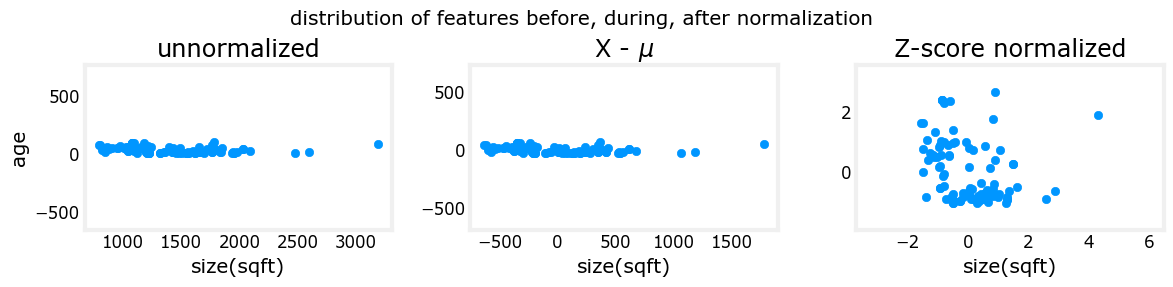

In [130]:
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)
X_mean = (X_train - mu)
X_norm = (X_train - mu) / sigma
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:, 0], X_train[:, 3])
ax[0].set_xlabel(X_features[0])
ax[0].set_ylabel(X_features[3])
ax[0].set_title("unnormalized")
ax[0].axis('equal')
ax[1].scatter(X_mean[:, 0], X_mean[:, 3])
ax[1].set_xlabel(X_features[0])
ax[0].set_ylabel(X_features[3])
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')
ax[2].scatter(X_norm[:, 0], X_norm[:, 3])
ax[2].set_xlabel(X_features[0])
ax[0].set_ylabel(X_features[3])
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')
plt.tight_layout(rect=(0, 0.03, 1, 0.95))
fig.suptitle("distribution of features before, during, after normalization")
plt.show()

上图显示了两个训练集参数“年龄”和“平方英尺”之间的关系。 *这些都是以等比例绘制的*。

- 左：未标准化：“尺寸（平方英尺）”特征的值范围或方差远大于年龄的范围
- 中：第一步查找从每个特征中删除平均值。这留下了以零为中心的特征。很难看出“年龄”特征的差异，但“尺寸（平方英尺）”显然在零左右。
- 右：第二步除以方差。这使得两个特征都以零为中心，具有相似的尺度。

让我们对数据进行标准化并将其与原始数据进行比较。

In [131]:
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train, axis=0)}")
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm, axis=0)}")

X_mu = [1.42e+03 2.72e+00 1.38e+00 3.84e+01], 
X_sigma = [411.62   0.65   0.49  25.78]
Peak to Peak range by column in Raw        X:[2.41e+03 4.00e+00 1.00e+00 9.50e+01]
Peak to Peak range by column in Normalized X:[5.85 6.14 2.06 3.69]


通过归一化，每列的峰峰值范围从数千倍减少到2-3倍。

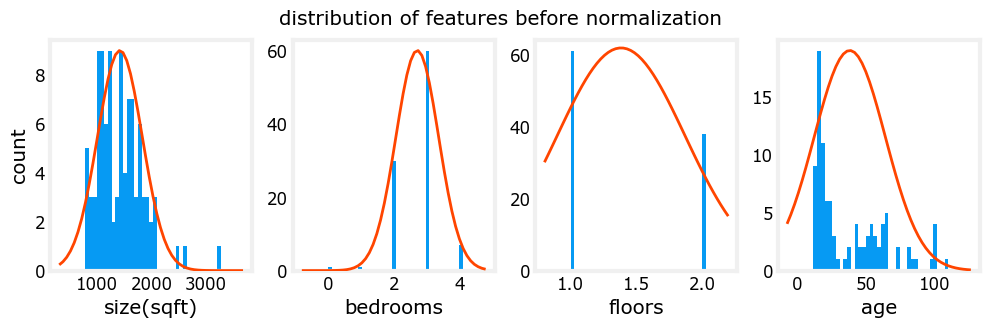

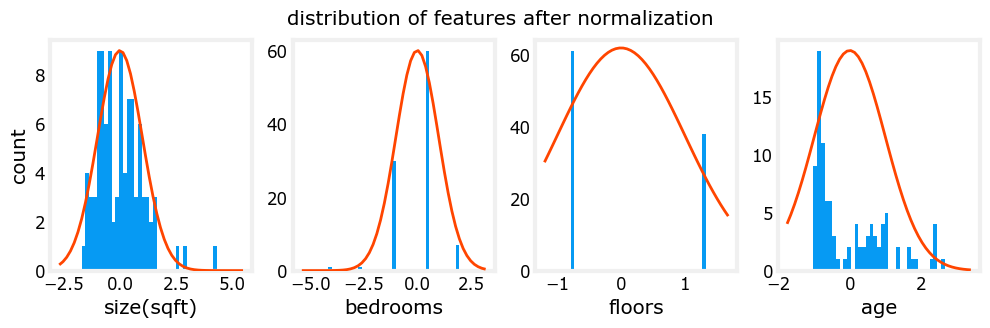

In [132]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i], X_train[:, i], )
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count")
fig.suptitle("distribution of features before normalization")
plt.show()
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i], X_norm[:, i], )
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count")
fig.suptitle(f"distribution of features after normalization")
plt.show()

请注意，上面标准化数据的范围以零为中心，大致为+/-1。最重要的是，每个特征的范围都是相似的。

让我们用归一化数据重新运行梯度下降算法。

请注意**大得多的$\alpha$值**。这将加速下降。

In [133]:
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, 1000, 1.0e-1, )

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 5.76170e+04  8.9e+00  3.0e+00  3.3e+00 -6.0e+00  3.6e+01 -8.9e+01 -3.0e+01 -3.3e+01  6.0e+01 -3.6e+02
      100 2.21086e+02  1.1e+02 -2.0e+01 -3.1e+01 -3.8e+01  3.6e+02 -9.2e-01  4.5e-01  5.3e-01 -1.7e-01 -9.6e-03
      200 2.19209e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.0e-02  1.5e-02  1.7e-02 -6.0e-03 -2.6e-07
      300 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.0e-03  5.1e-04  5.7e-04 -2.0e-04 -6.9e-12
      400 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.4e-05  1.7e-05  1.9e-05 -6.6e-06 -2.7e-13
      500 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.1e-06  5.6e-07  6.2e-07 -2.2e-07 -2.6e-13
      600 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.7e-08  1.9e-08  2.1e-08 -7.3e-09 -

缩放后的特征获得非常准确的结果**快得多！**。请注意，在这个相当短的运行结束时，每个参数的梯度都很小。0.1的学习率是使用归一化特征进行回归的良好开端。

让我们绘制预测值与目标值的关系图。请注意，预测是使用归一化特征进行的，而绘图是使用原始特征值显示的。

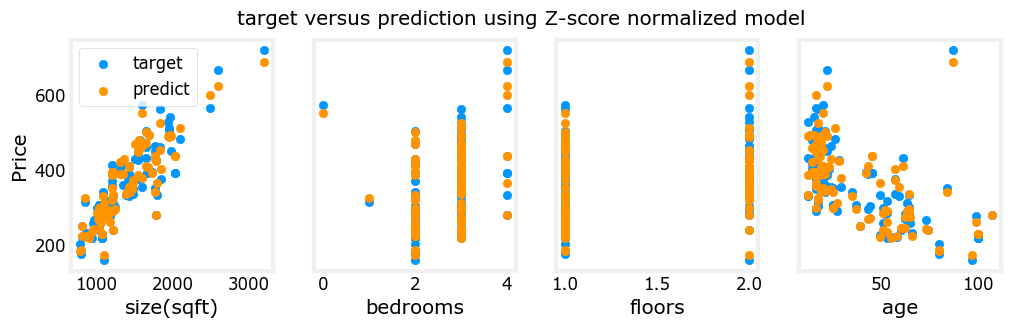

In [134]:
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp,color=dlorange, label = 'predict')
ax[0].set_ylabel("Price")
ax[0].legend()
fig.suptitle("target versus prediction using Z-score normalized model")
plt.show()

结果看起来不错。 有几点需要注意：

- 对于多个特征，我们不能再用一个图来显示结果与特征的关系。
- 生成绘图时，使用归一化特征。 使用从标准化训练集中学习到的参数进行的任何预测也必须进行标准化。

**预言**

生成模型的目的是用它来预测数据集中没有的房价。我们来预测一套1200平方英尺、3间卧室、1层、40年楼龄的房子的价格。回想一下，您必须使用训练数据标准化时得出的平均值和标准差来标准化数据。

In [135]:
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + b_norm
print(f" predicted price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = ${x_house_predict*1000:0.0f}")

[-0.53  0.43 -0.79  0.06]
 predicted price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = $318709


**成本轮廓**

<img align="left" src="../../images/C1_W2_Lab06_contours.PNG" style="width:240px;" >

查看特征缩放的另一种方法是根据成本等值线。当特征尺度不匹配时，等值线图中成本与参数的关系图是不对称的。

在下图中，参数的比例是匹配的。左图是w[0]（平方英尺）与w[1]（标准化特征之前的卧室数量）的成本等高线图。该图非常不对称，以至于看不到完成轮廓的曲线。相反，当特征标准化时，成本轮廓更加对称。结果是，在梯度下降期间更新参数可以使每个参数取得相同的进展。

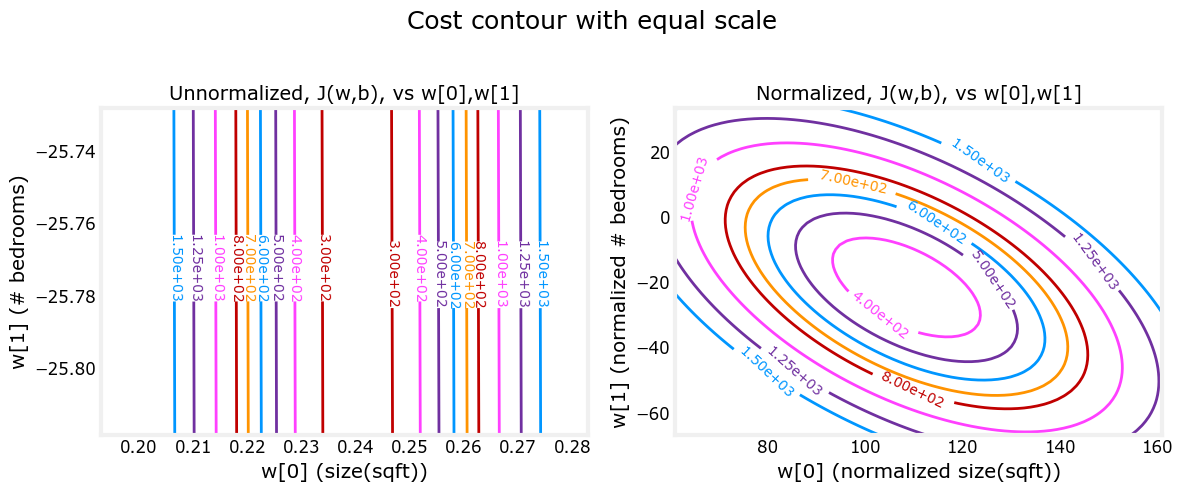

In [136]:
plt_equal_scale(X_train, X_norm, y_train)

## 恭喜！

在本实验室中，您：

- 利用线性回归例程以及您在之前实验室中开发的多个功能
- 探讨了学习率$\alpha$对收敛的影响
- 发现使用Z-score归一化进行特征缩放在加速收敛方面的价值